## Imports and preparations

In [1]:
import pandas as pd
import numpy as np
import csv
import math
from matplotlib import pyplot as plt
from calendar import month_abbr
from preprocessing_utils import transform_categorical_column, parse_browser_col
from time import strptime
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, impute
from model_estimation import estimate_model_performance
from preprocessing_utils import EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder, MONTH_COL, standardize_data
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
test_data = pd.read_csv("test.csv")

## Data Exploration

### We will start with a glimpse of data and its features:

In [4]:
print(f"Data description:")
train_data.describe()

Data description:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [5]:
print(f"Data glimpse:")
train_data.head()

Data glimpse:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


In [6]:
print(f"Number of rows: {train_data.shape[0]}")
print(f"Number of features: {train_data.shape[1]}")

Number of rows: 10479
Number of features: 23


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479 entries, 0 to 10478
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10479 non-null  int64  
 1   num_of_admin_pages     9874 non-null   float64
 2   admin_page_duration    10066 non-null  float64
 3   num_of_info_pages      9792 non-null   float64
 4   info_page_duration     10162 non-null  object 
 5   num_of_product_pages   10076 non-null  float64
 6   product_page_duration  9858 non-null   object 
 7   total_duration         5726 non-null   float64
 8   BounceRates            10457 non-null  float64
 9   ExitRates              10453 non-null  float64
 10  PageValues             10452 non-null  float64
 11  closeness_to_holiday   9983 non-null   float64
 12  Month                  10454 non-null  object 
 13  device                 10156 non-null  float64
 14  internet_browser       9916 non-null   object 
 15  Re

At first, we tried to look at the data and get familiar with it how it looks, and which data types are used for each column.
We used df.describe, df. head and df.info to just have a glimpse at the data and "feel" how it behaves.
It will later help us to understand how we would like to manipulate it in our favor.

### Let's try to see how that data distributes:

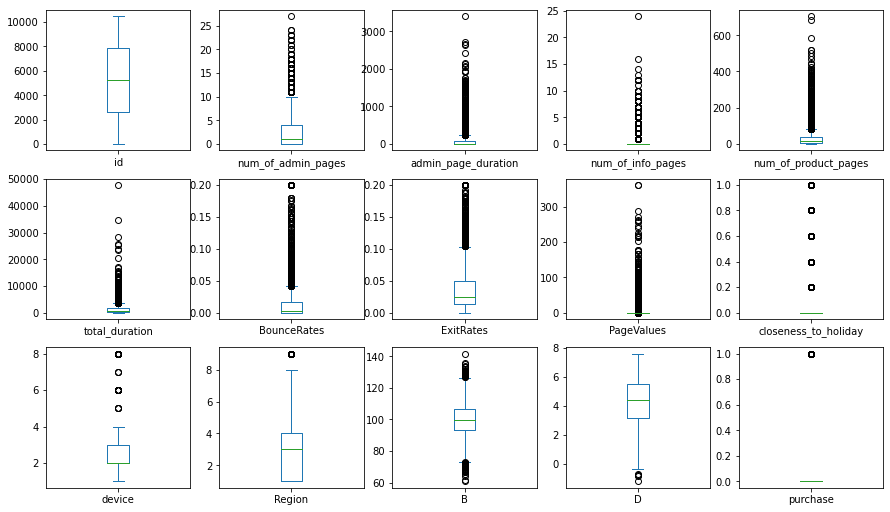

In [9]:
train_data.plot(kind="box", subplots=True,layout = (5,5), figsize=(15,15));

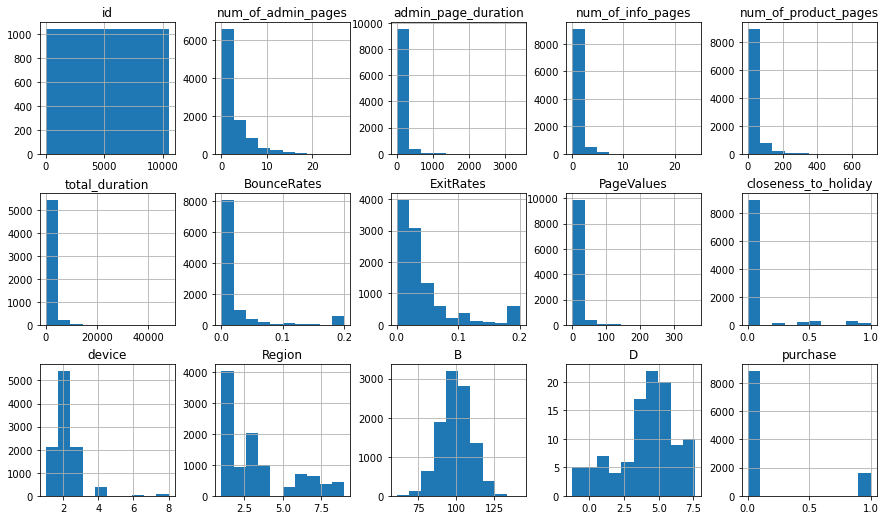

In [10]:
train_data.hist(layout = (5,5), figsize=(15,15));

These two plots help us understand a few things:
1. Not all of the columns are relevant for plotting as they are - like ID and purchase. These are fixed values and it's irrelevant to see their distributions.
2. Some of the coulums are normally distributed, or close to it - like column "B", "D" and "Device".
3. We can easily identify some of the otliers. For example - the values "6" and "8" in "Device" column, some of the durations etc. We will deal with it in a later stage.

In [11]:
#TODO: Add Miki's correlation plot

## Data cleaning

The next thing we want to check out is whether we have missing data. We did see in the data glimpse that some of the values are filled with NaNs, so we we'd like to see what's the best way to deal with it.

In [4]:
clean_train_data = standardize_data(train_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.ORDINAL, MONTH_COL)
clean_train_data

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
0,0,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,...,1.0,2.0,0,c_1,118.880094,log202,NaN,0,3.0,15.0
1,1,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.200000,0.200000,...,9.0,2.0,0,c_3,113.358423,log404,NaN,0,3.0,14.0
2,2,0.0,0.0,0.0,0.0,NaN,627.500000,627.500000,0.020000,0.050000,...,1.0,2.0,1,c_4,121.507695,log202,NaN,0,0.0,3.0
3,3,0.0,0.0,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,...,1.0,2.0,0,c_3,93.747176,log_100,NaN,0,1.0,99.0
4,4,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,...,3.0,2.0,0,c_3,99.545824,log202,NaN,0,2.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,10474,3.0,145.0,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,...,1.0,2.0,1,c_1,79.548460,log400,NaN,0,0.0,6.0
10475,10475,0.0,0.0,0.0,0.0,5.0,465.750000,NaN,0.000000,0.021333,...,1.0,2.0,1,c_8,99.457255,log202,NaN,0,1.0,98.0
10476,10476,0.0,0.0,0.0,0.0,6.0,184.250000,NaN,0.083333,0.086667,...,1.0,2.0,1,c_13,94.417344,log8080,NaN,0,1.0,99.0
10477,10477,4.0,75.0,0.0,0.0,15.0,346.000000,NaN,0.000000,0.021053,...,3.0,2.0,0,c_11,108.919057,log400,NaN,0,1.0,80.0


In [5]:
data_summary = pd.DataFrame()
data_summary['missing'] = clean_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / clean_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
D,10374,98.997996
total_duration,4753,45.357381
A,706,6.737284
num_of_info_pages,687,6.555969
num_of_admin_pages,605,5.773452
closeness_to_holiday,496,4.733276
admin_page_duration,413,3.941216
num_of_product_pages,403,3.845787
device,323,3.082355
PageValues,27,0.257658


As we can see, column "D" and "total_duration" have the most NaN values. Let's try to see what's special about them:

In [118]:
clean_train_data[clean_train_data["D"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
34,34,0.0,0.000000,0.0,0.000000,9.0,482.000000,NaN,0.000000,0.022222,0.000000,0.0,2,2.0,1.0,2.0,0,c_6,97.305385,log8080,7.257361,0,0.0,5.0
179,179,2.0,40.000000,0.0,0.000000,5.0,558.500000,598.500000,0.000000,0.028571,0.000000,0.0,3,2.0,7.0,0.0,1,c_2,100.425325,log_100,5.521225,0,1.0,90.0
222,222,1.0,13.000000,0.0,0.000000,2.0,20.000000,NaN,0.000000,0.050000,0.000000,0.0,3,3.0,3.0,2.0,0,c_2,104.686348,log200,4.348781,0,1.0,98.0
328,328,4.0,61.000000,0.0,0.000000,14.0,175.666667,NaN,0.000000,0.010588,0.000000,0.0,3,2.0,5.0,2.0,0,c_2,93.755824,log202,5.011107,0,1.0,80.0
346,346,7.0,151.000000,0.0,0.000000,44.0,1406.100000,NaN,0.004082,0.006501,0.000000,0.0,3,1.0,4.0,2.0,0,c_2,83.061903,log200,5.531061,0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779,9779,0.0,0.000000,0.0,0.000000,12.0,1952.750000,NaN,0.033333,0.068333,0.000000,NaN,11,2.0,8.0,2.0,0,c_1,115.233372,log404,1.632070,0,2.0,99.0
9924,9924,0.0,0.000000,0.0,0.000000,57.0,1234.500000,NaN,0.001724,0.020690,0.000000,0.0,11,2.0,2.0,2.0,1,c_2,90.084329,log400,2.905838,0,0.0,7.0
10282,10282,10.0,260.250000,0.0,0.000000,31.0,1694.333333,1954.583333,0.017143,0.039048,15.108543,0.0,11,2.0,4.0,2.0,0,c_3,91.706110,log400,3.932566,0,1.0,99.0
10388,10388,0.0,0.000000,6.0,97.166667,81.0,3466.794048,NaN,0.018431,0.022050,0.000000,0.0,11,3.0,1.0,2.0,1,c_13,80.989223,log_100,4.842721,0,4.0,0.0


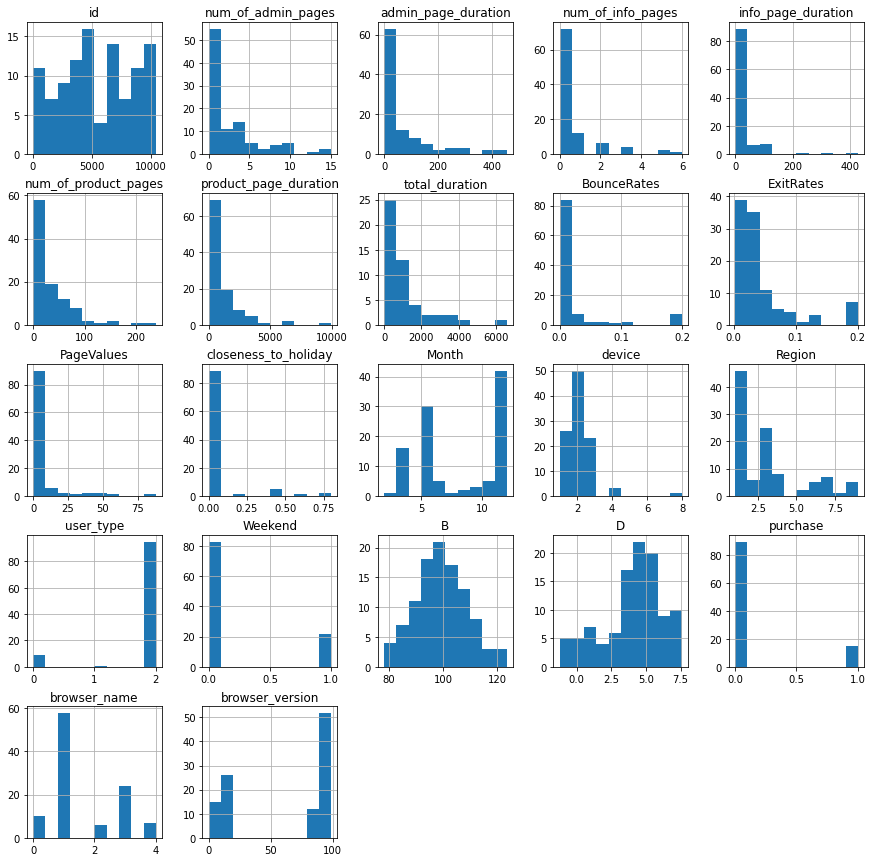

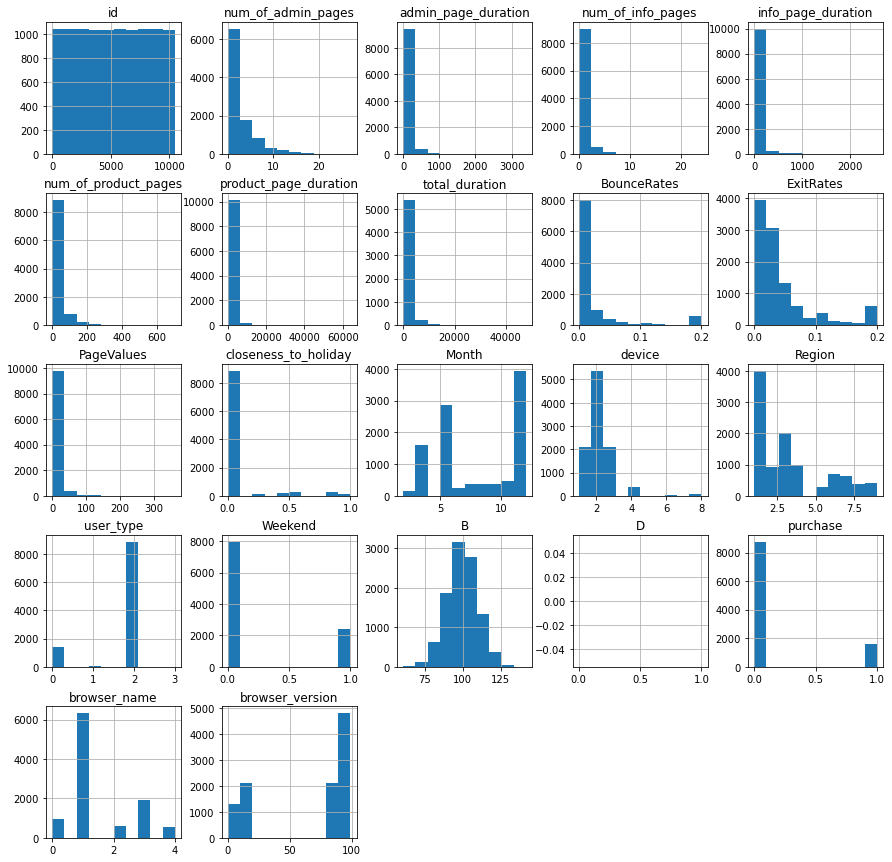

In [119]:
clean_train_data[clean_train_data["D"].notna()].hist(layout = (5,5), figsize=(15,15));
clean_train_data[clean_train_data["D"].isna()].hist(layout = (5,5), figsize=(15,15));

As there not seems to be much change in the data between empty and non empty "D" values, and we saw that the range for the "D" values are -1.23 to 7.61, we will fill it for now with -999.
Because we don't know what column D really stands for, and almost all of the values are empty, we prefer not to try to predict their values.

In [5]:
clean_train_data["D"] = clean_train_data["D"].fillna(-999)

Let's move to total_duration:

In [121]:
clean_train_data[clean_train_data["total_duration"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
1,1,0.0,0.00,0.0,0.0,1.0,0.000000,0.000000,0.200000,0.200000,0.000000,0.0,2,4.0,9.0,2.0,0,c_3,113.358423,log404,-999.0,0,3.0,14.0
2,2,0.0,0.00,0.0,0.0,NaN,627.500000,627.500000,0.020000,0.050000,0.000000,0.0,2,3.0,1.0,2.0,1,c_4,121.507695,log202,-999.0,0,0.0,3.0
3,3,0.0,0.00,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,0.000000,0.0,2,2.0,1.0,2.0,0,c_3,93.747176,log_100,-999.0,0,1.0,99.0
7,7,0.0,0.00,0.0,0.0,3.0,395.000000,395.000000,0.000000,0.066667,0.000000,0.0,2,1.0,3.0,2.0,0,c_3,101.184534,log_100,-999.0,0,3.0,15.0
9,9,0.0,0.00,0.0,0.0,7.0,280.500000,280.500000,0.000000,0.028571,0.000000,0.0,2,1.0,1.0,2.0,0,c_3,97.899633,log200,-999.0,0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10471,10471,0.0,0.00,0.0,0.0,6.0,0.000000,0.000000,0.200000,0.200000,0.000000,0.0,11,1.0,4.0,2.0,0,c_1,100.346528,log400,-999.0,0,0.0,8.0
10472,10472,6.0,76.25,0.0,0.0,22.0,1075.250000,1151.500000,0.000000,0.004167,0.000000,0.0,12,2.0,4.0,2.0,0,c_2,83.053502,log8080,-999.0,0,1.0,99.0
10473,10473,0.0,0.00,1.0,0.0,16.0,503.000000,503.000000,0.000000,0.037647,0.000000,0.0,11,2.0,1.0,2.0,0,c_1,95.296930,log400,-999.0,0,1.0,90.0
10474,10474,3.0,145.00,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,12.241717,0.0,12,4.0,1.0,2.0,1,c_1,79.548460,log400,-999.0,0,0.0,6.0


It seems that the total_duration column is empty even though other durations are filled with actual values. We will fill the empty values with the sum of the other values.
But first, we need to try and fill the other duration values.

For other fields, we will use KNN to try and fill-in the missing data. But first we will clean it a little bit.

First, we'd like to see the unique values of the columns, to see if we need to pay special attention for some of the column's predictions.

In [122]:
column_list = clean_train_data.columns.values.tolist()
column_list.sort()
for column_name in column_list:
    if column_name not in ['id', 'purchase']:
        print(f"""Column: "{column_name}" ; Unique values: {list(clean_train_data[column_name].unique())[:15]}""")

Column: "A" ; Unique values: ['c_1', 'c_3', 'c_4', 'c_2', nan, 'c_5', 'c_6', 'c_8', 'c_10', 'c_11', 'c_9', 'c_7', 'c_13', 'c_14', 'c_15']
Column: "B" ; Unique values: [118.8800944, 113.3584226, 121.5076952, 93.74717575, 99.54582421, 104.7124049, 89.78656794, 101.1845339, 83.93173925, 97.89963262, 101.2214824, 95.51998611, 109.3586319, 111.5479879, 113.2126221]
Column: "BounceRates" ; Unique values: [0.2, 0.02, 0.015789474, 0.0, 0.01875, 0.008333333, 0.002857143, 0.05, 0.043478261, 0.04, 0.014285714, 0.015384615, 0.025, 0.028571429, 0.003030303]
Column: "C" ; Unique values: ['log202', 'log404', 'log_100', 'log200', 'log400', 'log8080', nan]
Column: "D" ; Unique values: [-999.0, 7.257360853, 5.521225205, 4.34878126, 5.011107258, 5.531061246, 3.274955241, 0.796733734, 3.816877219, 0.058866821, 7.618253527, 4.826132322, 3.305456104, 5.386814934, 4.319823481]
Column: "ExitRates" ; Unique values: [0.2, 0.05, 0.024561404, 0.1, 0.022222222, 0.066666667, 0.025833333, 0.028571429, 0.016312636, 0

Now we can see that there are some columns that should be interpreted as integers, and not as floats (num_of_X_pages, region, device...).
In addition, it wouldn't be smart to assume column "A"'s and "C"'s empty values using KNN, since a value is fixed. We will use a different approach for it.

In addition, we will fill NaN values for user_type as Others, since we can't assume the real type.

In [6]:
int_cols = ['Month', 'device', 'num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages', 'Region']
dur_col_dict = {'info_page_duration': 'num_of_info_pages', 'admin_page_duration': 'num_of_admin_pages', 'product_page_duration': 'num_of_product_pages'}

for key in dur_col_dict:
    clean_train_data[key] = clean_train_data.apply(lambda row: row[key] == 0 if row["total_duration"] == 0 else row[key],axis=1)
    clean_train_data[key] = clean_train_data.apply(lambda row: row[key] == 0 if row[dur_col_dict[key]] == 0 else row[key], axis=1)

most_common_c = clean_train_data['C'].mode()
clean_train_data['C'] = clean_train_data['C'].fillna(200) #TODO: check why var doesn't work
clean_train_data['A'] = clean_train_data['A'].fillna('c_0')
clean_train_data['C'] = clean_train_data['C'].fillna(clean_train_data['C'].mode())

clean_train_data['A'] = clean_train_data['A'].str.extract('(\d+)', expand=False)
clean_train_data['A'] = clean_train_data['A'].astype(float)

clean_train_data['C'] = clean_train_data['C'].str.extract('(\d+)', expand=False)
clean_train_data['C'] = clean_train_data['C'].astype(float)


imputer = impute.KNNImputer(n_neighbors=3)
filled_train_data = pd.DataFrame(imputer.fit_transform(clean_train_data),columns = clean_train_data.columns)

for col in int_cols:
    filled_train_data[col] = filled_train_data[col].apply(lambda x: round(x))

Now that we finally have all the durations, we can fill in the total duration NaN values with the sum of all other duration columns.

In [7]:
filled_train_data['total_duration'] = filled_train_data.apply(lambda row: row['info_page_duration'] + row['product_page_duration'] + row['admin_page_duration'], axis=1)

In [9]:
pd.set_option('display.max_columns', None)
filled_train_data.head()

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
0,0.0,0,1.0,0,1.0,1,0.000000,2.000000,0.200000,0.200000,0.0,0.0,2,1,1,2.0,0.0,1.0,118.880094,202.0,-999.0,0.0,3.0,15.0
1,1.0,0,0.0,0,0.0,1,1.000000,1.000000,0.200000,0.200000,0.0,0.0,2,4,9,2.0,0.0,3.0,113.358423,404.0,-999.0,0.0,3.0,14.0
2,2.0,0,1.0,0,1.0,17,627.500000,629.500000,0.020000,0.050000,0.0,0.0,2,3,1,2.0,1.0,4.0,121.507695,202.0,-999.0,0.0,0.0,3.0
3,3.0,0,1.0,0,1.0,19,154.216667,156.216667,0.015789,0.024561,0.0,0.0,2,2,1,2.0,0.0,3.0,93.747176,100.0,-999.0,0.0,1.0,99.0
4,4.0,0,1.0,0,1.0,1,0.000000,2.000000,0.200000,0.200000,0.0,0.4,2,2,3,2.0,0.0,3.0,99.545824,202.0,-999.0,0.0,2.0,96.0


Finally, let's see that filled in all the NaN values and make sure that it didn't mess our data completely.

In [10]:
data_summary = pd.DataFrame()
data_summary['missing'] = filled_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / filled_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
num_of_admin_pages,0,0.0
browser_name,0,0.0
purchase,0,0.0
D,0,0.0
C,0,0.0
B,0,0.0
A,0,0.0
Weekend,0,0.0
user_type,0,0.0


Mofified data:


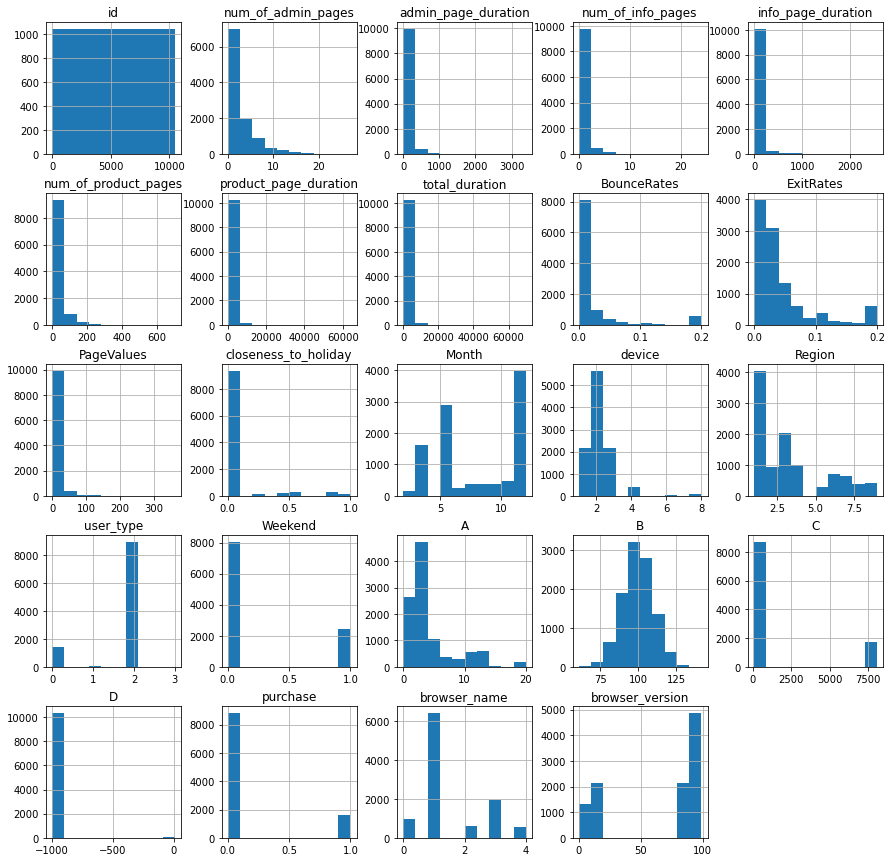

In [11]:
print("Mofified data:")
filled_train_data.hist(layout = (5,5), figsize=(15,15));

### Now we will implement it on the test set as well.

In [8]:
clean_test_data = standardize_data(test_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.ORDINAL, MONTH_COL)

clean_test_data["D"] = clean_test_data["D"].fillna(-999)

int_cols = ['Month', 'device', 'num_of_admin_pages', 'num_of_info_pages', 'num_of_product_pages', 'Region']
dur_col_dict = {'info_page_duration': 'num_of_info_pages', 'admin_page_duration': 'num_of_admin_pages', 'product_page_duration': 'num_of_product_pages'}

for key in dur_col_dict:
    clean_test_data[key] = clean_test_data.apply(lambda row: row[key] == 0 if row["total_duration"] == 0 else row[key],axis=1)
    clean_test_data[key] = clean_test_data.apply(lambda row: row[key] == 0 if row[dur_col_dict[key]] == 0 else row[key], axis=1)

most_common_c = clean_test_data['C'].mode()
clean_test_data['C'] = clean_test_data['C'].fillna(200) #TODO: check why var doesn't work
clean_test_data['A'] = clean_test_data['A'].fillna('c_0')
clean_test_data['C'] = clean_test_data['C'].fillna(clean_train_data['C'].mode())

clean_test_data['A'] = clean_test_data['A'].str.extract('(\d+)', expand=False)
clean_test_data['A'] = clean_test_data['A'].astype(float)

clean_test_data['C'] = clean_test_data['C'].str.extract('(\d+)', expand=False)
clean_test_data['C'] = clean_test_data['C'].astype(float)


imputer = impute.KNNImputer(n_neighbors=3)
filled_test_data = pd.DataFrame(imputer.fit_transform(clean_test_data),columns = clean_test_data.columns)

for col in int_cols:
    filled_test_data[col] = filled_test_data[col].apply(lambda x: round(x))

In [13]:
data_summary_test = pd.DataFrame()
data_summary_test['missing'] = filled_test_data.isna().sum()
data_summary_test['percentile'] = (data_summary_test.missing / filled_test_data.shape[0]) * 100
data_summary_test.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
Month,0,0.0
browser_name,0,0.0
D,0,0.0
C,0,0.0
B,0,0.0
A,0,0.0
Weekend,0,0.0
user_type,0,0.0
Region,0,0.0


#

## Removing outliers

During the data exploration we already notice that our data containes possible outliers.
Outliers could cause our predictions to be inaccurate, so we would like to remove potential outliers before moving forward.
To make sure we remove only absolute outliers, we will use a zscore test.

In [9]:
z_scores = stats.zscore(filled_train_data)
z_scores

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
0,-1.731886,-0.700375,-0.443572,-0.399416,-0.235969,-0.692191,-0.587685,-0.606999,3.702001,3.250320,...,-0.896863,0.401263,-0.547247,-0.692998,1.903022,-0.469049,-0.100605,-0.427783,1.413999,-1.270624
1,-1.731555,-0.700375,-0.449246,-0.399416,-0.243121,-0.692191,-0.587163,-0.607490,3.702001,3.250320,...,2.432005,0.401263,-0.547247,-0.197016,1.353123,-0.399818,-0.100605,-0.427783,1.413999,-1.295809
2,-1.731224,-0.700375,-0.443572,-0.399416,-0.235969,-0.331289,-0.260349,-0.299271,-0.039286,0.146454,...,-0.896863,0.401263,1.827329,0.050976,2.164703,-0.469049,-0.100605,-0.427783,-1.411213,-1.572841
3,-1.730894,-0.700375,-0.443572,-0.399416,-0.235969,-0.286177,-0.507237,-0.531371,-0.126801,-0.379933,...,-0.896863,0.401263,-0.547247,-0.197016,-0.599945,-0.504007,-0.100605,-0.427783,-0.469476,0.844898
4,-1.730563,-0.700375,-0.443572,-0.399416,-0.235969,-0.692191,-0.587685,-0.606999,3.702001,3.250320,...,-0.064646,0.401263,-0.547247,-0.197016,-0.022462,-0.469049,-0.100605,-0.427783,0.472262,0.769344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,1.730563,0.211293,0.373508,-0.399416,-0.235969,0.480739,0.342832,0.338398,-0.306521,-0.287454,...,-0.896863,0.401263,1.827329,-0.692998,-2.013984,-0.401189,-0.100605,-0.427783,-1.411213,-1.497287
10475,1.730894,-0.700375,-0.443572,-0.399416,-0.235969,-0.601966,-0.344726,-0.378594,-0.454985,-0.446730,...,-0.896863,0.401263,1.827329,1.042940,-0.031283,-0.469049,-0.100605,-0.427783,-0.469476,0.819713
10476,1.731224,-0.700375,-0.443572,-0.399416,-0.235969,-0.579409,-0.491571,-0.516642,1.277093,0.905177,...,-0.896863,0.401263,1.827329,2.282896,-0.533204,2.230941,-0.100605,-0.427783,-0.469476,0.844898
10477,1.731555,0.515182,-0.023684,-0.399416,-0.235969,-0.376402,-0.407193,-0.401029,-0.454985,-0.452538,...,-0.064646,0.401263,-0.547247,1.786914,0.911010,-0.401189,-0.100605,-0.427783,-0.469476,0.366387


In [10]:
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_data_wo_outliers = filled_train_data[filtered_entries]

print(f"Original shape: {filled_train_data.shape}")
print(f"New shape: {train_data_wo_outliers.shape}")

Original shape: (10479, 24)
New shape: (8271, 24)


## Now we can run our first model!

Model predictions runtime: 0.0012917518615722656s
Accuracy score: 0.8876132930513595
MSE: 0.11238670694864049


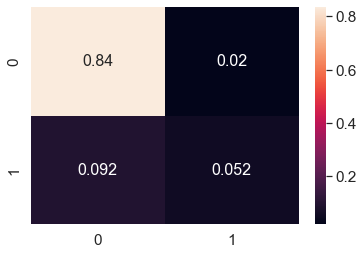

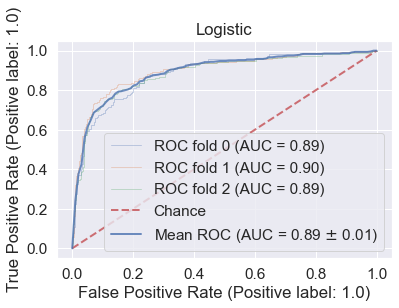

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_data_wo_outliers.loc[:, train_data_wo_outliers.columns != 'purchase'], train_data_wo_outliers['purchase'], test_size=0.2)

lr = LogisticRegression(max_iter=1000000).fit(X_train, y_train)

estimate_model_performance(lr, "Logistic", X_test, y_test, 3);
